# Data Challenge 2 - Yammer - Jeremy Ferlic - February 27, 2019

## Problem Description

Yammer is a social network for communicating with coworkers. Individuals share documents, updates, and ideas by posting them in groups, it’s like Slack. Yammer is free to use indefinitely, but companies must pay license fees if they want access to administrative controls, including integration with user management systems like ActiveDirectory.

On the morning of September 2, 2014, the head of the product team noticed something strange about the latest activity on the user engagement dashboards, as measured by the number of unique "engaged" users each week.  An engaged user is one who has made a call to the Yammer servers corresponding to an "engagement" activity.  The anomaly the product team head noticed was that up until August 1, there was a steady increase in the number of engaged users, but after August 1, there appears to be a decrease in this number.  Our goal is to use the data available to investigate this scenario.

## Data & Description

For this problem, data are available from four different databases: (1) a users table, (2) an events table, (3) an emails table, and (4) a date-rollup table. The first three items all contain a user_id, which can be used to link the information together.  The users table contains descriptive information about the user's account.  The events table is organized as one row per event, where an event is some action that a user of Yammer's platform has taken.  The emails table contains information related to the sending of emails, and includes actions such as receiving the weekly digest email and clicking a link in an email.  The rollup table is used to define time intervals of interest.

## Assumptions

## Package Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
%matplotlib inline

## Loading in Data

In [ ]:
# Read in various data frames
users = pd.read_csv("yammer_users.csv")
events = pd.read_csv("yammer_events.csv")
emails = pd.read_csv("yammer_emails.csv")
rollups = pd.read_csv("dimension_rollup_periods.csv")

# Convert to date-times
events['occurred_at'] =  pd.to_datetime(events['occurred_at'])
rollups['pst_start'] =  pd.to_datetime(rollups['pst_start'])
rollups['pst_end'] =  pd.to_datetime(rollups['pst_end'])

# The problem description only mentions the week-long periods with code 1007 as of interest
rollups = rollups[rollups['period_id'] == 1007]

### Creating events dataframe

In [3]:
# Use SQL commands to join the events to certain roll-ups
conn = sqlite3.connect(':memory:')

events.to_sql('events', conn, index=False)
rollups.to_sql('rollups', conn, index=False)
qry = '''
    SELECT  
        *
    FROM events 
    JOIN rollups 
    ON events.occurred_at between rollups.pst_start and pst_end 
    '''
df_events = pd.read_sql_query(qry, conn)
conn.close()

In [4]:
# Use SQL commands to join the events to user information
conn = sqlite3.connect(':memory:')

df_events.to_sql('df', conn, index=False)
users.to_sql('users', conn, index=False)
qry = '''
    SELECT  
        *
    FROM df 
    LEFT JOIN users USING(user_id)
    '''
df_events = pd.read_sql_query(qry, conn)
conn.close()

In [5]:
print(df_events.shape)
print(df_events.columns)
print(df_events.head())

(2385824, 18)
Index(['user_id', 'occurred_at', 'event_type', 'event_name', 'location',
       'device', 'user_type', 'period_id', 'time_id', 'pst_start', 'pst_end',
       'utc_start', 'utc_end', 'created_at', 'company_id', 'language',
       'activated_at', 'state'],
      dtype='object')
   user_id          occurred_at  event_type event_name location  \
0  10522.0  2014-05-02 11:02:39  engagement      login    Japan   
1  10522.0  2014-05-02 11:02:39  engagement      login    Japan   
2  10522.0  2014-05-02 11:02:39  engagement      login    Japan   
3  10522.0  2014-05-02 11:02:39  engagement      login    Japan   
4  10522.0  2014-05-02 11:02:39  engagement      login    Japan   

                   device  user_type  period_id              time_id  \
0  dell inspiron notebook        3.0     1007.0  2014-05-03 00:00:00   
1  dell inspiron notebook        3.0     1007.0  2014-05-04 00:00:00   
2  dell inspiron notebook        3.0     1007.0  2014-05-05 00:00:00   
3  dell inspiron n

### Creating emails dataframe

In [6]:
# Use SQL commands to join the emails to certain roll-ups
conn = sqlite3.connect(':memory:')

emails.to_sql('emails', conn, index=False)
rollups.to_sql('rollups', conn, index=False)
qry = '''
    SELECT  
        *
    FROM emails 
    JOIN rollups 
    ON emails.occurred_at between rollups.pst_start and pst_end 
    '''
df_emails = pd.read_sql_query(qry, conn)
conn.close()

In [7]:
# Use SQL commands to join the emails to user information
conn = sqlite3.connect(':memory:')

df_emails.to_sql('df', conn, index=False)
users.to_sql('users', conn, index=False)
qry = '''
    SELECT  
        *
    FROM df 
    LEFT JOIN users USING(user_id)
    '''
df_emails = pd.read_sql_query(qry, conn)
conn.close()

In [8]:
print(df_emails.shape)
print(df_emails.columns)
print(df_emails.head())

(632723, 15)
Index(['user_id', 'occurred_at', 'action', 'user_type', 'period_id', 'time_id',
       'pst_start', 'pst_end', 'utc_start', 'utc_end', 'created_at',
       'company_id', 'language', 'activated_at', 'state'],
      dtype='object')
   user_id          occurred_at              action  user_type  period_id  \
0      0.0  2014-05-06 09:30:00  sent_weekly_digest        1.0     1007.0   
1      0.0  2014-05-06 09:30:00  sent_weekly_digest        1.0     1007.0   
2      0.0  2014-05-06 09:30:00  sent_weekly_digest        1.0     1007.0   
3      0.0  2014-05-06 09:30:00  sent_weekly_digest        1.0     1007.0   
4      0.0  2014-05-06 09:30:00  sent_weekly_digest        1.0     1007.0   

               time_id            pst_start              pst_end  \
0  2014-05-07 00:00:00  2014-04-30 00:00:00  2014-05-07 00:00:00   
1  2014-05-08 00:00:00  2014-05-01 00:00:00  2014-05-08 00:00:00   
2  2014-05-09 00:00:00  2014-05-02 00:00:00  2014-05-09 00:00:00   
3  2014-05-10 00:00:00

## Exploratory Analysis

### Event Data

In [35]:
# Use SQL commands to count distinct users for each time_id
conn = sqlite3.connect(':memory:')

df_events.to_sql('df', conn, index=False)
users.to_sql('users', conn, index=False)
qry = '''
    SELECT  
        time_id, event_type, COUNT(DISTINCT df.user_id) AS activity
    FROM
        df
    GROUP BY time_id, event_type
    '''
df2 = pd.read_sql_query(qry, conn)
conn.close()

event_type
engagement     AxesSubplot(0.125,0.125;0.775x0.755)
signup_flow    AxesSubplot(0.125,0.125;0.775x0.755)
Name: activity, dtype: object

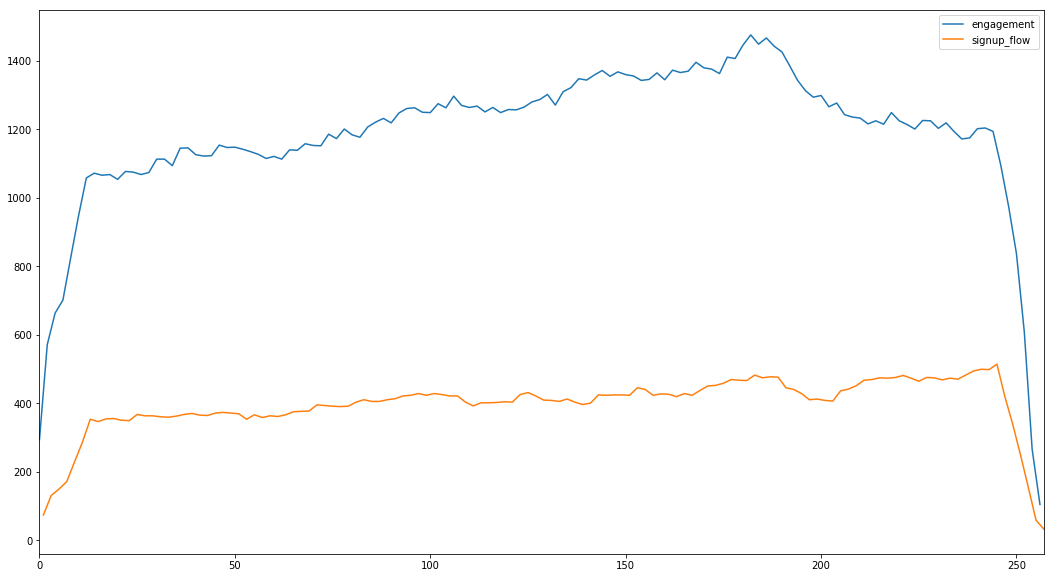

In [36]:
# Plot by event_type (engagement or signup)
fig, ax = plt.subplots(figsize=(18,6))
ax.legend(loc=1)
df2.groupby(['event_type'])['activity'].plot(ax=ax, legend=True, figsize=(18,10))

In [43]:
# When did we reach our max engagement
df2.iloc[df2['activity'].idxmax()]
peak = df2.iloc[df2['activity'].idxmax()]['time_id']
print(peak)

2014-08-01 00:00:00


We are able to recreate the trend that the head of the department showed us.  We see that our peak engagement time occurred on August 1 before the downward trend.  We can see a similar trend in signup flow, but on to a much smaller extend; there is a dip in sign-ups, but not enough to be the driver in the trend we see in engagement.

### Email Data

In [12]:
print(df_emails.columns)

Index(['user_id', 'occurred_at', 'action', 'user_type', 'period_id', 'time_id',
       'pst_start', 'pst_end', 'utc_start', 'utc_end', 'created_at',
       'company_id', 'language', 'activated_at', 'state'],
      dtype='object')


In [13]:
# Use SQL commands to count unique number of users receiving emails
conn = sqlite3.connect(':memory:')

df_emails.to_sql('df', conn, index=False)
users.to_sql('users', conn, index=False)
qry = '''
    SELECT  
        time_id, COUNT(DISTINCT df.user_id) AS activity
    FROM
        df
    GROUP BY time_id
    '''
df2 = pd.read_sql_query(qry, conn)
conn.close()

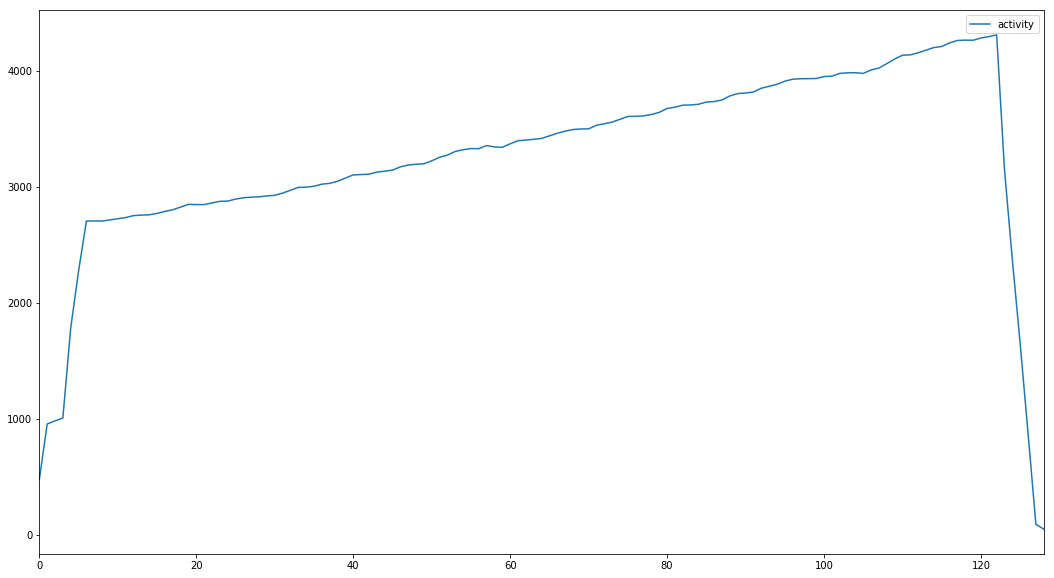

In [14]:
# Plot
fig, ax = plt.subplots(figsize=(18,6))
ax.legend(loc=1)
df2['activity'].plot(ax=ax, legend=True, figsize=(18,10))

In [15]:
# When did we see our highest email engagement numbers
df2.iloc[df2['activity'].idxmax()]

time_id     2014-09-01 00:00:00
activity                   4309
Name: 122, dtype: object

We don't see any such trend in total email activity.  There may be a small dip around the same time as the engagement dip, but nothing visually significant.  We can still dig down deeper to explore the email events.

## Exploring the Event Data

### By Event Name

event_name
home_page                 AxesSubplot(0.125,0.125;0.775x0.755)
like_message              AxesSubplot(0.125,0.125;0.775x0.755)
login                     AxesSubplot(0.125,0.125;0.775x0.755)
search_autocomplete       AxesSubplot(0.125,0.125;0.775x0.755)
search_click_result_1     AxesSubplot(0.125,0.125;0.775x0.755)
search_click_result_10    AxesSubplot(0.125,0.125;0.775x0.755)
search_click_result_2     AxesSubplot(0.125,0.125;0.775x0.755)
search_click_result_3     AxesSubplot(0.125,0.125;0.775x0.755)
search_click_result_4     AxesSubplot(0.125,0.125;0.775x0.755)
search_click_result_5     AxesSubplot(0.125,0.125;0.775x0.755)
search_click_result_6     AxesSubplot(0.125,0.125;0.775x0.755)
search_click_result_7     AxesSubplot(0.125,0.125;0.775x0.755)
search_click_result_8     AxesSubplot(0.125,0.125;0.775x0.755)
search_click_result_9     AxesSubplot(0.125,0.125;0.775x0.755)
search_run                AxesSubplot(0.125,0.125;0.775x0.755)
send_message              AxesSubplot(0.125,

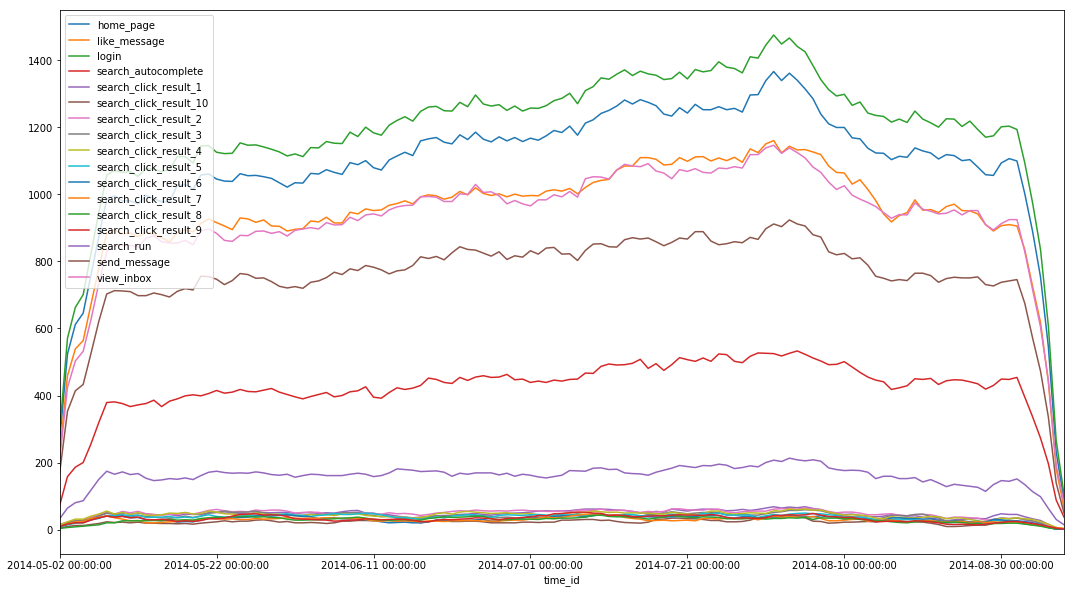

In [40]:
# Use SQL commands to join the events to certain roll-ups
conn = sqlite3.connect(':memory:')

df_events.to_sql('df', conn, index=False)
qry = '''
    SELECT  
        time_id, event_type, event_name, COUNT(DISTINCT user_id) AS count
    FROM
        df
    WHERE
        event_type = 'engagement'
    GROUP BY time_id, event_type, event_name
    '''
df3 = pd.read_sql_query(qry, conn)
conn.close()
#print(df3)

fig, ax = plt.subplots(figsize=(18,6))
ax.legend(loc=1)

df3.set_index('time_id', inplace=True)
df3.groupby(['event_name'])['count'].plot(ax=ax, legend=True, figsize=(18,10))
#ax.axvline(x=peak)

The dip in engagement seems to happen in the most frequent engagement types, those being logins, visits to the home page, like messages, and search auto-completes.  This suggests that users are not visiting the Yammer page to begin with and means we can most likely rule out a catastrophic event where one of our search functions would have broken.

In [17]:
df_events.columns

Index(['user_id', 'occurred_at', 'event_type', 'event_name', 'location',
       'device', 'user_type', 'period_id', 'time_id', 'pst_start', 'pst_end',
       'utc_start', 'utc_end', 'created_at', 'company_id', 'language',
       'activated_at', 'state'],
      dtype='object')

### By User Language

language
arabic       AxesSubplot(0.125,0.125;0.775x0.755)
chinese      AxesSubplot(0.125,0.125;0.775x0.755)
english      AxesSubplot(0.125,0.125;0.775x0.755)
french       AxesSubplot(0.125,0.125;0.775x0.755)
german       AxesSubplot(0.125,0.125;0.775x0.755)
indian       AxesSubplot(0.125,0.125;0.775x0.755)
italian      AxesSubplot(0.125,0.125;0.775x0.755)
japanese     AxesSubplot(0.125,0.125;0.775x0.755)
korean       AxesSubplot(0.125,0.125;0.775x0.755)
portugese    AxesSubplot(0.125,0.125;0.775x0.755)
russian      AxesSubplot(0.125,0.125;0.775x0.755)
spanish      AxesSubplot(0.125,0.125;0.775x0.755)
Name: count, dtype: object

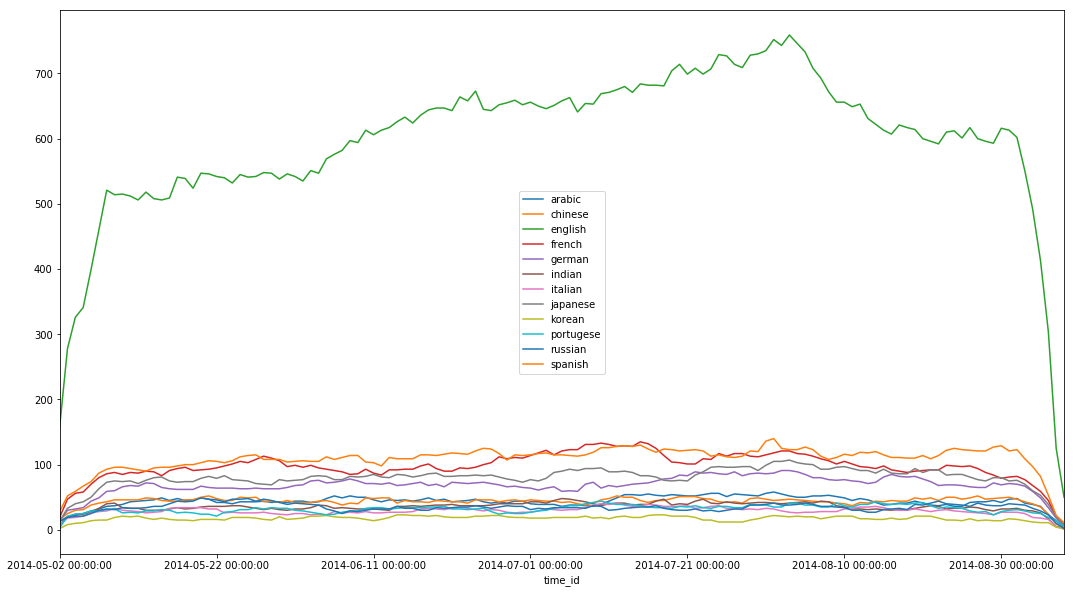

In [18]:
# Use SQL commands to join the events to certain roll-ups
conn = sqlite3.connect(':memory:')

df_events.to_sql('df', conn, index=False)
qry = '''
    SELECT  
        time_id, language, COUNT(DISTINCT user_id) AS count
    FROM
        df
    WHERE
        event_type = 'engagement'
    GROUP BY time_id, language
    '''
df3 = pd.read_sql_query(qry, conn)
conn.close()
#print(df3)

df3.set_index('time_id', inplace=True)
df3.groupby('language')['count'].plot(legend=True, figsize=(18,10))

In this plot, segmenting the users by language, we can see that a majority of our users are visiting the site in english, and they are also the major cause of our dip.  None of the other languages appear to have a dip around the same time.

### By User Location

location
Argentina               AxesSubplot(0.125,0.125;0.775x0.755)
Australia               AxesSubplot(0.125,0.125;0.775x0.755)
Austria                 AxesSubplot(0.125,0.125;0.775x0.755)
Belgium                 AxesSubplot(0.125,0.125;0.775x0.755)
Brazil                  AxesSubplot(0.125,0.125;0.775x0.755)
Canada                  AxesSubplot(0.125,0.125;0.775x0.755)
Chile                   AxesSubplot(0.125,0.125;0.775x0.755)
Colombia                AxesSubplot(0.125,0.125;0.775x0.755)
Denmark                 AxesSubplot(0.125,0.125;0.775x0.755)
Egypt                   AxesSubplot(0.125,0.125;0.775x0.755)
Finland                 AxesSubplot(0.125,0.125;0.775x0.755)
France                  AxesSubplot(0.125,0.125;0.775x0.755)
Germany                 AxesSubplot(0.125,0.125;0.775x0.755)
Greece                  AxesSubplot(0.125,0.125;0.775x0.755)
Hong Kong               AxesSubplot(0.125,0.125;0.775x0.755)
India                   AxesSubplot(0.125,0.125;0.775x0.755)
Indonesia      

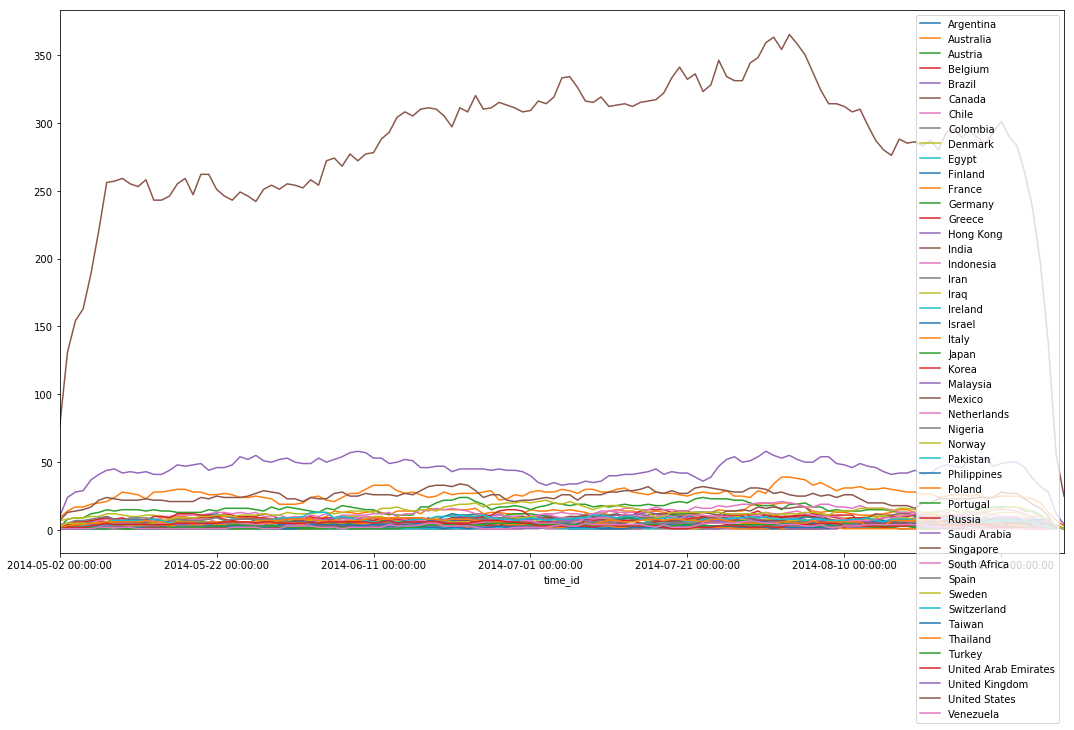

In [28]:
# Use SQL commands to join the events to certain roll-ups
conn = sqlite3.connect(':memory:')

df_events.to_sql('df', conn, index=False)
qry = '''
    SELECT  
        time_id, location, COUNT(DISTINCT user_id) AS count
    FROM
        df
    WHERE
        event_type = 'engagement' AND language = 'english'
    GROUP BY time_id, location
    '''
df3 = pd.read_sql_query(qry, conn)
conn.close()
#print(df3)

df3.set_index('time_id', inplace=True)
df3.groupby('location')['count'].plot(legend=True, figsize=(18,10))

Similarly, it would appear that the dip is being caused by users in the United States, who are by far our biggest customer location segment.

### By User Device Type

device
acer aspire desktop       AxesSubplot(0.125,0.125;0.775x0.755)
acer aspire notebook      AxesSubplot(0.125,0.125;0.775x0.755)
amazon fire phone         AxesSubplot(0.125,0.125;0.775x0.755)
asus chromebook           AxesSubplot(0.125,0.125;0.775x0.755)
dell inspiron desktop     AxesSubplot(0.125,0.125;0.775x0.755)
dell inspiron notebook    AxesSubplot(0.125,0.125;0.775x0.755)
hp pavilion desktop       AxesSubplot(0.125,0.125;0.775x0.755)
htc one                   AxesSubplot(0.125,0.125;0.775x0.755)
ipad air                  AxesSubplot(0.125,0.125;0.775x0.755)
ipad mini                 AxesSubplot(0.125,0.125;0.775x0.755)
iphone 4s                 AxesSubplot(0.125,0.125;0.775x0.755)
iphone 5                  AxesSubplot(0.125,0.125;0.775x0.755)
iphone 5s                 AxesSubplot(0.125,0.125;0.775x0.755)
kindle fire               AxesSubplot(0.125,0.125;0.775x0.755)
lenovo thinkpad           AxesSubplot(0.125,0.125;0.775x0.755)
mac mini                  AxesSubplot(0.125,0.12

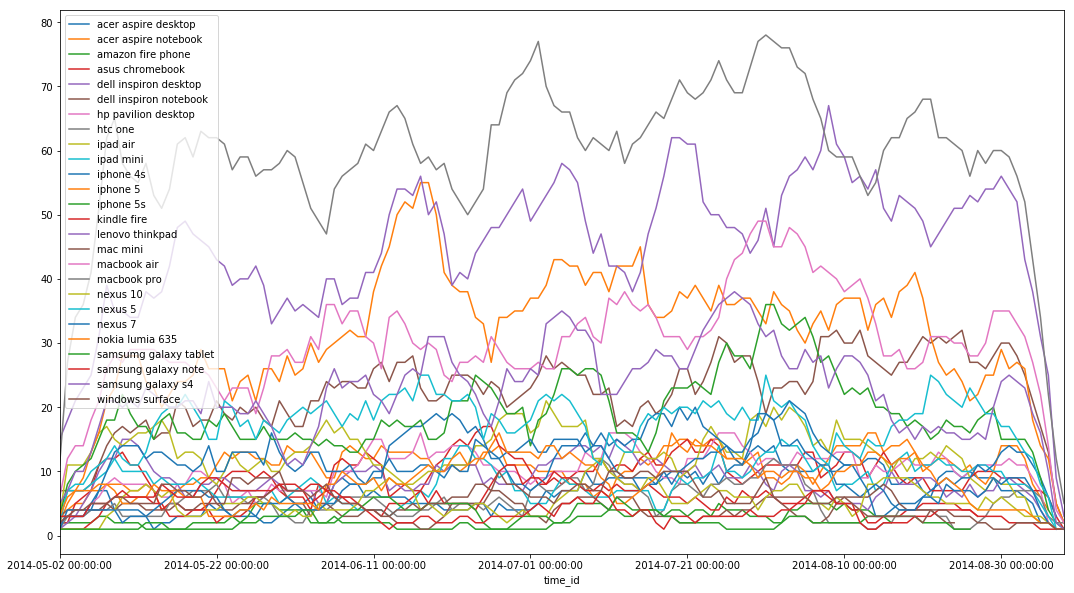

In [29]:
# Use SQL commands to join the events to certain roll-ups
conn = sqlite3.connect(':memory:')

df_events.to_sql('df', conn, index=False)
qry = '''
    SELECT  
        time_id, device, COUNT(DISTINCT user_id) AS count
    FROM
        df
    WHERE
        event_type = 'engagement' AND language = 'english' AND location = 'United States'
    GROUP BY time_id, device
    '''
df3 = pd.read_sql_query(qry, conn)
conn.close()
#print(df3)

df3.set_index('time_id', inplace=True)
df3.groupby('device')['count'].plot(legend=True, figsize=(18,10))

In general, it would seem that the device information for users is too noisy to make any solid statement about.  Some general observations include that the macbook pro users dip around the same time we see the global dip in engagement.  Of course we can't really draw any causal conclusions from this data, such as a bug in the mac operating system is causing our low numbers because it may be that our system changed at that time and is no longer as compatible with macs, so our system numbers are actually the driver of the macbook pro effect.

### By User Company

company_id
1.0        AxesSubplot(0.125,0.125;0.775x0.755)
2.0        AxesSubplot(0.125,0.125;0.775x0.755)
3.0        AxesSubplot(0.125,0.125;0.775x0.755)
4.0        AxesSubplot(0.125,0.125;0.775x0.755)
5.0        AxesSubplot(0.125,0.125;0.775x0.755)
6.0        AxesSubplot(0.125,0.125;0.775x0.755)
7.0        AxesSubplot(0.125,0.125;0.775x0.755)
8.0        AxesSubplot(0.125,0.125;0.775x0.755)
9.0        AxesSubplot(0.125,0.125;0.775x0.755)
10.0       AxesSubplot(0.125,0.125;0.775x0.755)
11.0       AxesSubplot(0.125,0.125;0.775x0.755)
12.0       AxesSubplot(0.125,0.125;0.775x0.755)
13.0       AxesSubplot(0.125,0.125;0.775x0.755)
14.0       AxesSubplot(0.125,0.125;0.775x0.755)
15.0       AxesSubplot(0.125,0.125;0.775x0.755)
16.0       AxesSubplot(0.125,0.125;0.775x0.755)
17.0       AxesSubplot(0.125,0.125;0.775x0.755)
18.0       AxesSubplot(0.125,0.125;0.775x0.755)
19.0       AxesSubplot(0.125,0.125;0.775x0.755)
20.0       AxesSubplot(0.125,0.125;0.775x0.755)
21.0       AxesSubplot(0.125,

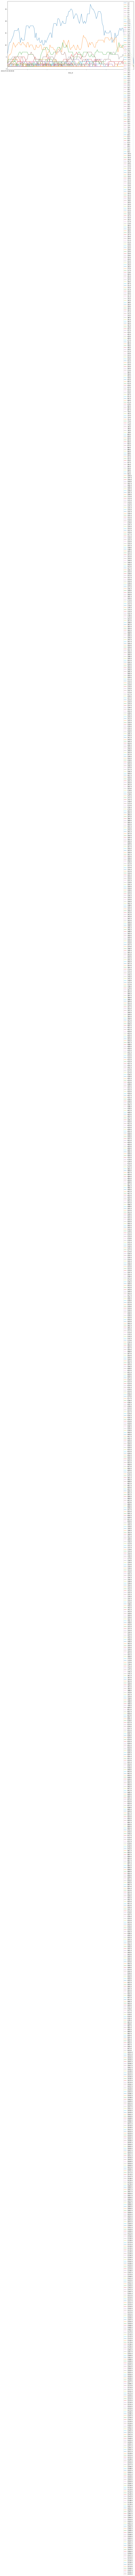

In [41]:
# Use SQL commands to join the events to certain roll-ups
conn = sqlite3.connect(':memory:')

df_events.to_sql('df', conn, index=False)
qry = '''
    SELECT  
        time_id, company_id, COUNT(DISTINCT user_id) AS count
    FROM
        df
    WHERE
        event_type = 'engagement' AND location = 'United States'
    GROUP BY time_id, company_id
    '''
df3 = pd.read_sql_query(qry, conn)
conn.close()
#print(df3)

df3.to_csv("byCompany.csv")
df3.set_index('time_id', inplace=True)
df3.groupby('company_id')['count'].plot(legend=True, figsize=(18,10))

Here we can see that that US market for our product is actually quite diverse.  There are a few companies that "seem" to dominate the field, but if we look at the magnitude of our Y-axis (engagement numbers), we  see that even the top company has a maximum of 27 users in a week.  That's not very large.  It can be tempting to say that company 1 is driving the trend, but that can't be the case.  More likely, a bunch of smaller companies together are driving the trend we see.

In [22]:
# When did we see our highest email engagement numbers
df3.loc[df3['count'].idxmax()]

,company_id,count
time_id,,
2014-07-25 00:00:00,1.0,27
2014-07-25 00:00:00,2.0,10
2014-07-25 00:00:00,3.0,5
2014-07-25 00:00:00,4.0,4
2014-07-25 00:00:00,6.0,7
2014-07-25 00:00:00,7.0,3
2014-07-25 00:00:00,8.0,2
2014-07-25 00:00:00,9.0,1
2014-07-25 00:00:00,10.0,1


## Exploring Email Data

### By Action

In [23]:
df_emails.columns

Index(['user_id', 'occurred_at', 'action', 'user_type', 'period_id', 'time_id',
       'pst_start', 'pst_end', 'utc_start', 'utc_end', 'created_at',
       'company_id', 'language', 'activated_at', 'state'],
      dtype='object')

action
email_clickthrough         AxesSubplot(0.125,0.125;0.775x0.755)
email_open                 AxesSubplot(0.125,0.125;0.775x0.755)
sent_reengagement_email    AxesSubplot(0.125,0.125;0.775x0.755)
sent_weekly_digest         AxesSubplot(0.125,0.125;0.775x0.755)
Name: count, dtype: object

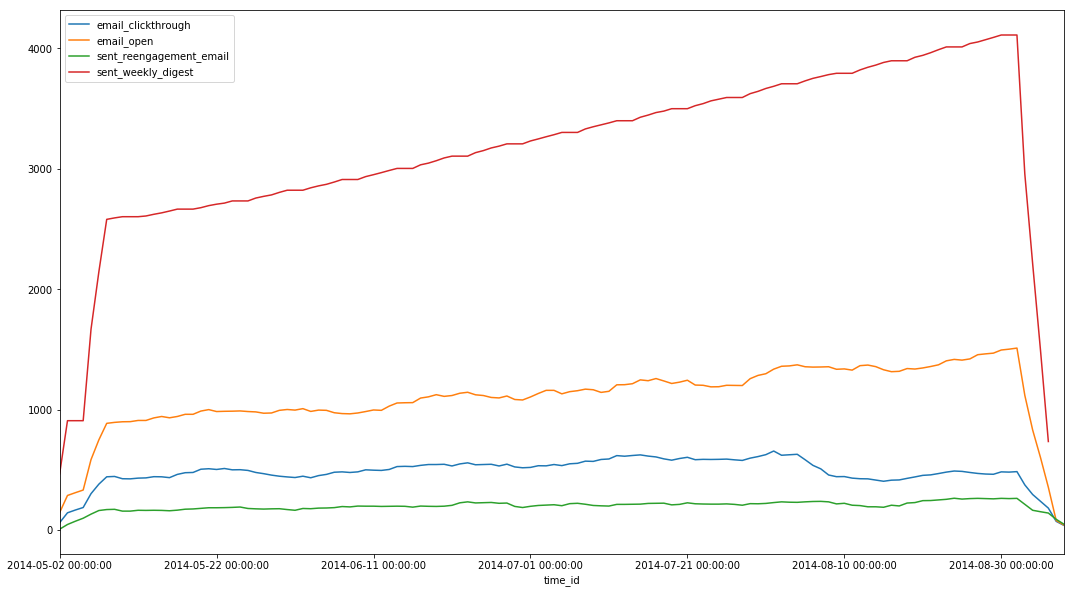

In [24]:
# Use SQL commands to join the events to certain roll-ups
conn = sqlite3.connect(':memory:')

df_emails.to_sql('df', conn, index=False)
qry = '''
    SELECT  
        time_id, action, COUNT(DISTINCT user_id) AS count
    FROM
        df
    GROUP BY time_id, action
    '''
df3 = pd.read_sql_query(qry, conn)
conn.close()
#print(df3)

df3.set_index('time_id', inplace=True)
df3.groupby('action')['count'].plot(legend=True, figsize=(18,10))

Here we can see that there seems to be a dip in clickthrough rates at the same time we see the dip in engagement.  Perhaps this is driving the trend.  Did something change about our emails around this time?  Did a link break in the emails?  Or did the emails somehow become less appealing to customers?  No other negative trends are visible in email data, so we know we're still sending the weekly digest emails and users are still opening them; they're just not clicking through.